### 1. Data preparation

In [226]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# Load data
checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])
gym_data = pd.read_csv("../data/_raw/gym_locations_data.csv")
user_data = pd.read_csv("../data/_raw/users_data.csv")

workout_data = checkin_data.merge(user_data[['user_id', 'age', 'gender']], on='user_id', how='left')
workout_data = workout_data.merge(gym_data[['gym_id', 'gym_type']], on='gym_id', how='left')
workout_data = workout_data.merge(user_data[['user_id','subscription_plan']], on='user_id', how='left')
workout_data['age_group'] = pd.cut(
    workout_data['age'],
    bins=[0, 18, 30, 60, 65],
    labels=['Teen', 'Young Adult', 'Adult', 'Senior'],
    include_lowest=True,
    ordered=False
)

### 2. Standardizing the data

In [227]:
workout_label_encoder = LabelEncoder()
gender_label_encoder = LabelEncoder()
age_group_label_encoder = LabelEncoder()
subscription_label_encoder = LabelEncoder()

workout_data['workout_type_standardized'] = workout_label_encoder.fit_transform(workout_data['workout_type'])
workout_data['gender_standardized'] = gender_label_encoder.fit_transform(workout_data['gender'])
workout_data['age_group_standardized'] = age_group_label_encoder.fit_transform(workout_data['age_group'])
workout_data['subscription_standardized'] = subscription_label_encoder.fit_transform(workout_data['gym_type'])

### 3. Data Split

Splitting data into test and training data and identifying optimal accuracy

In [229]:
# Standardize data
# Define variables and target
X = workout_data[['age_group_standardized', 'gender_standardized', 'subscription_standardized']]
y = workout_data['workout_type_standardized']
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store results
lambda_interval = np.logspace(-4, 2, 15)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))

# Loop over lambda values
for k in range(len(lambda_interval)):
    mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[k], max_iter=1000, multi_class='ovr')
    
    # Perform cross-validation
    scores = cross_val_score(mdl, X, y, cv=kf)
    y_pred = cross_val_predict(mdl, X, y, cv=kf)
    
    # Calculate and store mean cross-validation accuracy
    train_error_rate[k] = 1 - scores.mean()
    
    # Fit model on the whole dataset to get coefficients
    mdl.fit(X, y)
    w_est = mdl.coef_[0]
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

# Choose the best lambda based on the lowest error rate
opt_lambda_idx = np.argmin(train_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

# Train the final model with optimal lambda
final_model = LogisticRegression(penalty="l2", C=1 / opt_lambda, max_iter=1000, multi_class='ovr')
final_model.fit(X, y)

# Predict using cross-validation on the whole dataset
y_pred = cross_val_predict(final_model, X, y, cv=kf)

# Evaluate model
accuracy = accuracy_score(y, y_pred)
print(f"Cross-validated Accuracy: {accuracy:.2f}")


Cross-validated Accuracy: 0.17


# Logistic Regression Classification

Logistic Regression Classification is a statistical algorithm.
It is a binary classification, evaluation the accucary of the prediction model by determining True Positives (TP), True Negative (TN), False Positives (FP) and False Negatives (FN)

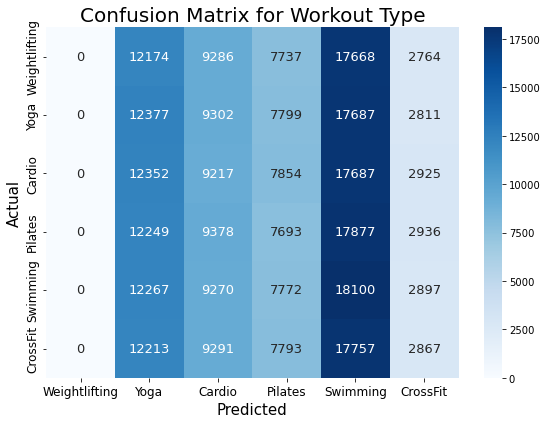

In [230]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=['Weightlifting', 'Yoga', 'Cardio', 'Pilates', 'Swimming', 'CrossFit'],  
    yticklabels=['Weightlifting', 'Yoga', 'Cardio', 'Pilates', 'Swimming', 'CrossFit'],  
    annot_kws={"size": 13}  
)
plt.title("Confusion Matrix for Workout Type", size=20, loc="center")
plt.xlabel('Predicted', size=15)
plt.ylabel('Actual', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('../data/plots/confusion_matrix.pdf')


The confusion matrix shows the performance of the logistic regression in predicting workout types based on age and gender.
The model isn't good at differentiating between the workout types effectively. 

# Decision Tree Classification

In [231]:
xaxis_dict = {0: ['Adult', 'Senior', 'Young Adult', 'Teen']}
yaxis_dict = {0: ["Female", "Male", "Non-binary"],
              1: ["Pro", "Basic", "Student"]}

# Define variables and target
X = workout_data[['age_group_standardized', 'gender_standardized', 'subscription_standardized']]
y = workout_data['workout_type_standardized']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree Accuracy: 0.16813333333333333
Decision Tree Accuracy: 0.16876666666666668


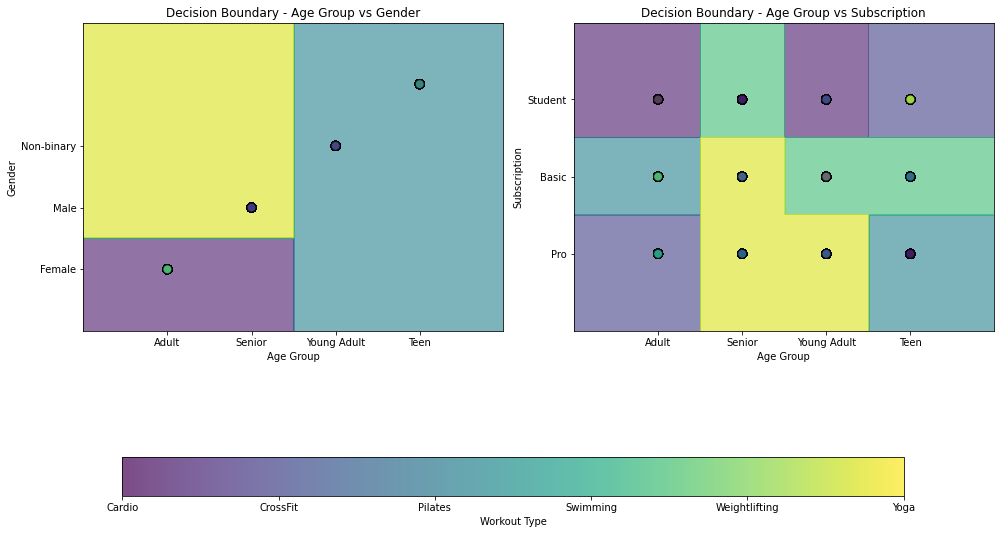

In [232]:
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

###################################################### AGE VS GENDER ######################################################
var1, var2 = 0, 0  # Index for 'Age Group' and 'Gender'
X_train_pair = X_train.iloc[:, [var1, var2]].values
X_test_pair = X_test.iloc[:, [var1, var2]].values

# Train the Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_pair, y_train)

# Create mesh grid boundaries
x_min, x_max = X_train_pair[:, 0].min() - 1, X_train_pair[:, 0].max() + 1
y_min, y_max = X_train_pair[:, 1].min() - 1, X_train_pair[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Evaluate Decision Tree
y_pred_tree = tree_model.predict(X_test_pair)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

# Predict on the mesh grid
Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
axes[0].contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.viridis)

# Scatter plot for prediction data
scatter = axes[0].scatter(X_test_pair[:, 0], X_test_pair[:, 1], c=y_test, cmap=plt.cm.viridis, edgecolor='k', s=80, alpha=0.7)

# Set labels and titles
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Gender')
axes[0].set_title(f"Decision Boundary - Age Group vs Gender")

axes[0].set_xticks([idx for idx in range(len(xaxis_dict[var1]))]) 
axes[0].set_xticklabels(xaxis_dict[var1]) 
axes[0].set_yticks([idx for idx in range(len(yaxis_dict[var2]))]) 
axes[0].set_yticklabels(yaxis_dict[var2])

###################################################### AGE VS SUBSCRIPTION ######################################################
var1, var2 = 0, 1  # Index for 'Age Group' and 'Gender'
X_train_pair = X_train.iloc[:, [var1, var2]].values
X_test_pair = X_test.iloc[:, [var1, var2]].values

# Train the Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_pair, y_train)

# Create mesh grid
x_min, x_max = X_train_pair[:, 0].min() - 1, X_train_pair[:, 0].max() + 1
y_min, y_max = X_train_pair[:, 1].min() - 1, X_train_pair[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Evaluate Decision Tree
y_pred_tree = tree_model.predict(X_test_pair)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

# Predict on the mesh grid
Z = tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
axes[1].contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.viridis)

# Scatter plot for prediction data
scatter = axes[1].scatter(X_test_pair[:, 0], X_test_pair[:, 1], c=y_test, cmap=plt.cm.viridis, edgecolor='k', s=80, alpha=0.7)

# Set labels and titles
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Subscription')
axes[1].set_title(f"Decision Boundary - Age Group vs Subscription")

axes[1].set_xticks([idx for idx in range(len(xaxis_dict[var1]))]) 
axes[1].set_xticklabels(xaxis_dict[var1]) 
axes[1].set_yticks([idx for idx in range(len(yaxis_dict[var2]))]) 
axes[1].set_yticklabels(yaxis_dict[var2])

# Add a colorbar below the plots
workout_labels = workout_label_encoder.inverse_transform(np.unique(workout_data['workout_type_standardized']))
colorbar_new = fig.colorbar(scatter, ax=axes, orientation='horizontal', pad=0., fraction=0.1)
colorbar_new.set_ticks(range(len(workout_labels)))
colorbar_new.ax.set_xticklabels(workout_labels)
colorbar_new.set_label("Workout Type")

plt.tight_layout(rect=[0, 0.4, 1, 1])
plt.savefig('../data/plots/decision_boundaries.pdf')

The Decision Tree predicts for each "case", what workout category they are classified into.
E.g. a teen female is categorized into the pilates category, while an adult male is categorized into a combination of yoga and weightlifting. 

At this point, due to the poor results, the data quality must be assessed

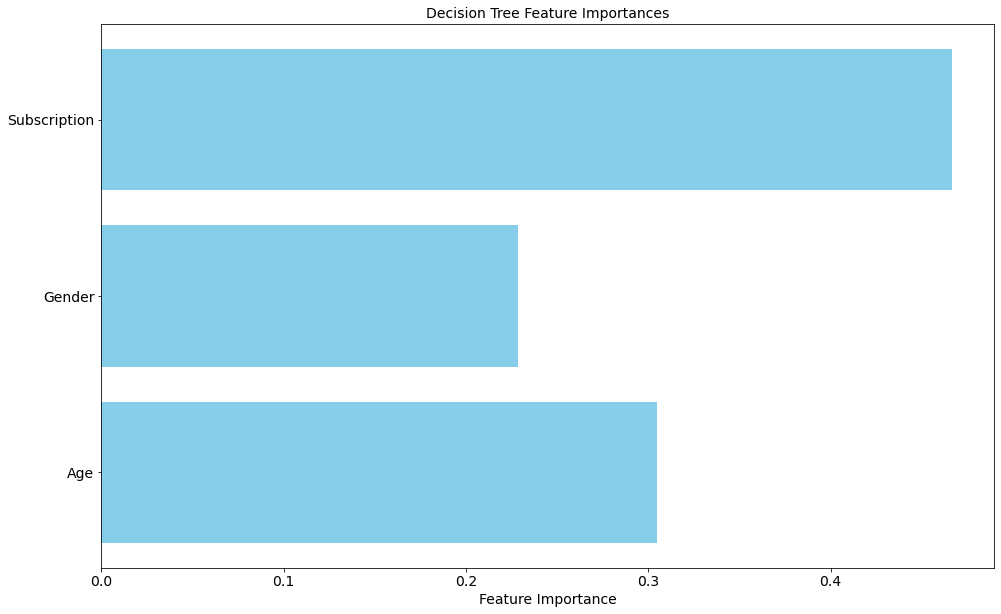

In [260]:
# Train the model and get feature importances
tree_model.fit(X, y)
importances = tree_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(16, 10))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(ticks=range(len(features)), labels=['Age', 'Gender', 'Subscription'], fontsize=14)
plt.title("Decision Tree Feature Importances", fontsize=14)
plt.savefig('../data/plots/feature_importance.pdf')

Finally, we started assuming that because of the data being artifically generated, our models aren't performing well. Therefore to further confirm or deny this, we performed a frequency heatmap of the features 'age' and 'workout type'. These features were chosen because 'age' contains many unique values and 'workout type', because this was the features relevant in this analysis

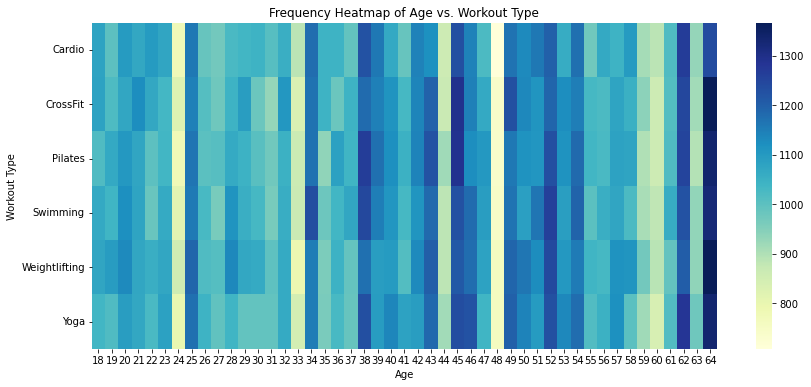

In [250]:
cross_tab = pd.crosstab(workout_data['workout_type'], workout_data['age'])

plt.figure(figsize=(14, 6))
sns.heatmap(cross_tab, annot=False, cmap='YlGnBu')
plt.title('Frequency Heatmap of Age vs. Workout Type')
plt.xlabel('Age')
plt.ylabel('Workout Type')
plt.savefig('../data/plots/frequency_table.pdf')